In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(32, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(1, activation=None)  # خروجی: w(x) یا theta(x)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

In [3]:
def load_function(x, load_type='uniform', magnitude=1.0, position=0.5, sigma=0.01):
    if load_type == 'uniform':
        return magnitude * tf.ones_like(x)
    elif load_type == 'point':
        return magnitude * tf.exp(-((x - position)**2) / (2 * sigma**2)) / (sigma * tf.sqrt(2 * np.pi))

In [4]:
def bending_loss(model, x, q_func):
    # محاسبه مشتقات PDE
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape() as tape:
            tape.watch(x)
            w = model(x)
        dw_dx = tape.gradient(w, x)
        d2w_dx2 = tape2.gradient(dw_dx, x)
        d3w_dx3 = tape2.gradient(d2w_dx2, x)
        d4w_dx4 = tape2.gradient(d3w_dx3, x)

    # معادله PDE: EI * d4w/dx4 = q(x), EI=1
    pde_residual = d4w_dx4 - q_func(x)
    pde_loss = tf.reduce_mean(tf.square(pde_residual))

    # شرایط مرزی برای تیر ساده
    x0 = tf.constant([[0.0]], dtype=tf.float32)
    x1 = tf.constant([[1.0]], dtype=tf.float32)

    with tf.GradientTape() as tape_bc0:
        tape_bc0.watch(x0)
        with tf.GradientTape() as tape_inner0:
            tape_inner0.watch(x0)
            w0 = model(x0)
        dw_dx0 = tape_inner0.gradient(w0, x0)
    d2w_dx2_0 = tape_bc0.gradient(dw_dx0, x0)

    with tf.GradientTape() as tape_bc1:
        tape_bc1.watch(x1)
        with tf.GradientTape() as tape_inner1:
            tape_inner1.watch(x1)
            w1 = model(x1)
        dw_dx1 = tape_inner1.gradient(w1, x1)
    d2w_dx2_1 = tape_bc1.gradient(dw_dx1, x1)

    bc_loss = tf.square(w0) + tf.square(w1) + tf.square(d2w_dx2_0) + tf.square(d2w_dx2_1)

    return pde_loss + 100 * bc_loss

In [5]:
def torsion_loss(model, x, t_func):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        theta = model(x)
        dtheta_dx = tape.gradient(theta, x)
        d2theta_dx2 = tape.gradient(dtheta_dx, x)

    # معادله PDE: GJ * d2theta/dx2 = -T(x), GJ=1
    pde_residual = d2theta_dx2 + t_func(x)

    # شرایط مرزی برای تیر گیردار
    x0 = tf.constant([[0.0]])
    x1 = tf.constant([[1.0]])
    theta0 = model(x0)
    theta1 = model(x1)

    bc_loss = tf.square(theta0) + tf.square(theta1)
    pde_loss = tf.reduce_mean(tf.square(pde_residual))
    return pde_loss + 100 * bc_loss

In [6]:
def train_model(model, x_train, loss_fn, epochs=5000):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x_train)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")
    return model

In [7]:
def fem_bending(L=1.0, n_elements=100, q=1.0, load_type='uniform'):
    dx = L / n_elements
    x = np.linspace(0, L, n_elements + 1)
    K = np.zeros((n_elements + 1, n_elements + 1))  # ماتریس سختی
    F = np.zeros(n_elements + 1)  # بردار نیرو

    # ماتریس سختی المان (EI=1)
    k_elem = (1 / dx**3) * np.array([[12, 6*dx, -12, 6*dx],
                                     [6*dx, 4*dx**2, -6*dx, 2*dx**2],
                                     [-12, -6*dx, 12, -6*dx],
                                     [6*dx, 2*dx**2, -6*dx, 4*dx**2]])

    # اسمبل کردن ماتریس سختی و نیرو
    for i in range(n_elements):
        K[i:i+2, i:i+2] += k_elem[0:2, 0:2] + k_elem[2:4, 2:4]
        F[i] += q * dx / 2 if load_type == 'uniform' else 0
        if load_type == 'point' and abs(x[i] - 0.5) < dx:
            F[i] += q

    # اعمال شرایط مرزی
    K[0, :] = 0; K[:, 0] = 0; K[0, 0] = 1; F[0] = 0
    K[-1, :] = 0; K[:, -1] = 0; K[-1, -1] = 1; F[-1] = 0

    w = np.linalg.solve(K, F)
    return x, w

def fem_torsion(L=1.0, n_elements=100, T=1.0, load_type='uniform'):
    dx = L / n_elements
    x = np.linspace(0, L, n_elements + 1)
    K = np.zeros((n_elements + 1, n_elements + 1))
    F = np.zeros(n_elements + 1)

    k_elem = (1 / dx) * np.array([[1, -1], [-1, 1]])  # GJ=1
    for i in range(n_elements):
        K[i:i+2, i:i+2] += k_elem
        F[i] += T * dx / 2 if load_type == 'uniform' else 0
        if load_type == 'point' and abs(x[i] - 0.5) < dx:
            F[i] += T

    K[0, :] = 0; K[:, 0] = 0; K[0, 0] = 1; F[0] = 0
    K[-1, :] = 0; K[:, -1] = 0; K[-1, -1] = 1; F[-1] = 0

    theta = np.linalg.solve(K, F)
    return x, theta

In [8]:
# نقاط آموزشی برای PINN
N = 100
x_train = tf.random.uniform((N, 1), minval=0, maxval=1)
x_test = np.linspace(0, 1, 100).reshape(-1, 1)

In [ ]:
# 1. خمش با بار گسترده
bending_model_uniform = PINN()
q_uniform = lambda x: load_function(x, 'uniform', 1.0)
bending_model_uniform = train_model(bending_model_uniform, x_train, 
                                    lambda m, x: bending_loss(m, x, q_uniform))
w_pinn_uniform = bending_model_uniform.predict(x_test)
x_fem, w_fem_uniform = fem_bending(load_type='uniform', q=1.0)

plt.figure()
plt.plot(x_test, w_pinn_uniform, label='PINN - Uniform Load')
plt.plot(x_fem, w_fem_uniform, '--', label='FEM - Uniform Load')
plt.legend()
plt.title("Bending: Uniform Load")
plt.show()

In [ ]:
# 2. خمش با بار متمرکز
bending_model_point = PINN()
q_point = lambda x: load_function(x, 'point', 1.0, position=0.5)
bending_model_point = train_model(bending_model_point, x_train, 
                                  lambda m, x: bending_loss(m, x, q_point))
w_pinn_point = bending_model_point.predict(x_test)
x_fem, w_fem_point = fem_bending(load_type='point', q=1.0)

plt.figure()
plt.plot(x_test, w_pinn_point, label='PINN - Point Load')
plt.plot(x_fem, w_fem_point, '--', label='FEM - Point Load')
plt.legend()
plt.title("Bending: Point Load")
plt.show()

Epoch 0, Loss: [[8.332522]]
Epoch 1000, Loss: [[0.05859687]]
Epoch 2000, Loss: [[0.00339288]]
Epoch 3000, Loss: [[0.00092002]]
Epoch 4000, Loss: [[0.00038145]]
4/4 [==============================] - 0s 333us/step


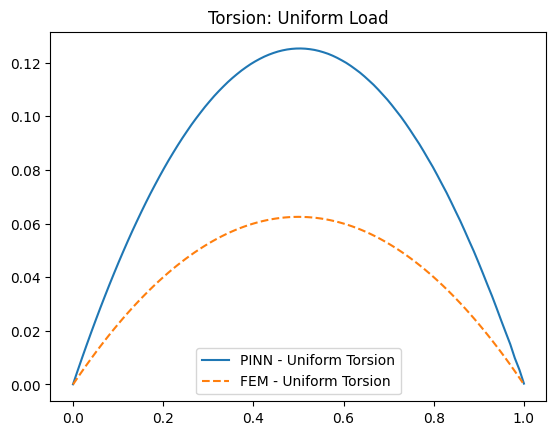

In [9]:
# 3. پیچش با بار گسترده
torsion_model_uniform = PINN()
t_uniform = lambda x: load_function(x, 'uniform', 1.0)
torsion_model_uniform = train_model(torsion_model_uniform, x_train, 
                                    lambda m, x: torsion_loss(m, x, t_uniform))
theta_pinn_uniform = torsion_model_uniform.predict(x_test)
x_fem, theta_fem_uniform = fem_torsion(load_type='uniform', T=1.0)

plt.figure()
plt.plot(x_test, theta_pinn_uniform, label='PINN - Uniform Torsion')
plt.plot(x_fem, theta_fem_uniform, '--', label='FEM - Uniform Torsion')
plt.legend()
plt.title("Torsion: Uniform Load")
plt.show()

In [ ]:
# 4. پیچش با بار متمرکز
torsion_model_point = PINN()
t_point = lambda x: load_function(x, 'point', 1.0, position=0.5)
torsion_model_point = train_model(torsion_model_point, x_train, 
                                  lambda m, x: torsion_loss(m, x, t_point))
theta_pinn_point = torsion_model_point.predict(x_test)
x_fem, theta_fem_point = fem_torsion(load_type='point', T=1.0)

plt.figure()
plt.plot(x_test, theta_pinn_point, label='PINN - Point Torsion')
plt.plot(x_fem, theta_fem_point, '--', label='FEM - Point Torsion')
plt.legend()
plt.title("Torsion: Point Load")
plt.show()